In [1]:
import os
import cv2
from sklearn.cluster import KMeans
from IPython.display import clear_output
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools
import networkx as nx
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import euclidean_distances
import seaborn as sns
import shutil

def read_img(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

## Read data

In [2]:
paths = os.listdir('result/faces')
paths = [path[:-4] for path in paths]
indices = np.array([int(path.split('_')[0]) for path in paths])

images = []
embeddings = []

for path in tqdm(paths):
    image = read_img(f'result/faces/{path}.jpg')
    embedding = np.load(f'result/embedding/{path}.npy')
    
    images.append(image)
    embeddings.append(embedding)
    
embeddings = np.vstack(embeddings)

100%|█████████████████████████████████████████████████████████████████████████████████| 59/59 [00:00<00:00, 990.41it/s]


## K mean clustering

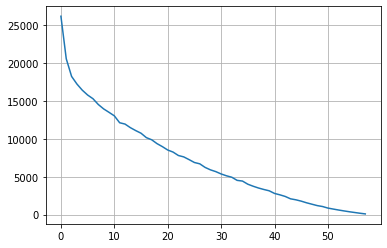

In [3]:
def run_kmeans(embeddings, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clusters = kmeans.fit_predict(embeddings)
    cluster_centers = kmeans.cluster_centers_
    
    loss = 0.0
    
    for i in range(num_clusters):
        cluster_points = embeddings[clusters == i]
        if len(cluster_points) > 0:
            cluster_center = cluster_centers[i]
            loss += np.sum((cluster_points - cluster_center) ** 2)
    return clusters, loss

k_values = range(1, len(images))

losses = []

for k in k_values:
    _, loss = run_kmeans(embeddings, num_clusters=k)
    clear_output(wait=True)
    losses.append(loss)
    plt.plot(losses)
    plt.grid()
    plt.show()

There are 31 clusters


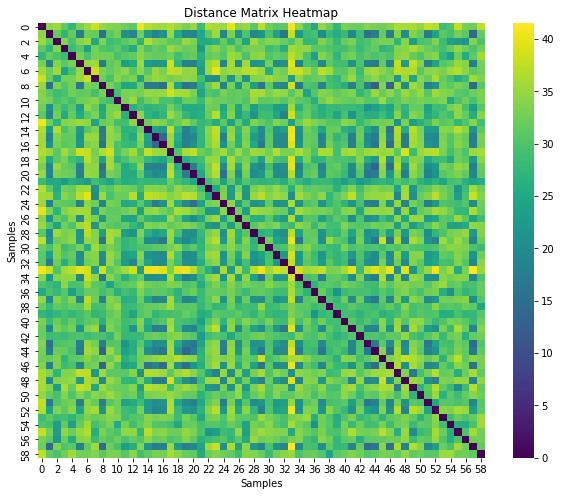

In [4]:
def run_dbscan(embeddings, eps=20, min_samples=1):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(embeddings)
    return dbscan.labels_

def plot_distance_matrix(embeddings):
    distance_matrix = euclidean_distances(embeddings)
    plt.figure(figsize=(10, 8))
    sns.heatmap(distance_matrix, cmap='viridis', annot=False)
    plt.title('Distance Matrix Heatmap')
    plt.xlabel('Samples')
    plt.ylabel('Samples')
    plt.show()

print(f'There are {len(np.unique(run_dbscan(embeddings)))} clusters')

plot_distance_matrix(embeddings)

### Plots clusters

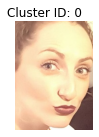

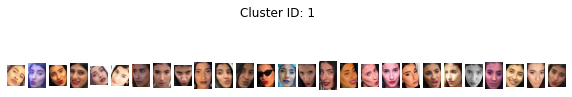

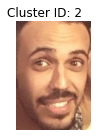

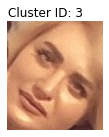

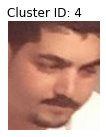

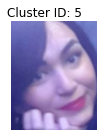

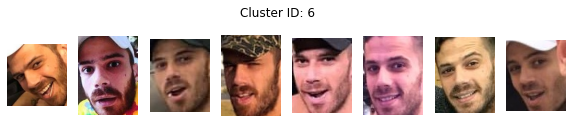

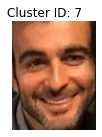

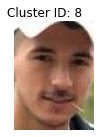

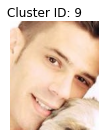

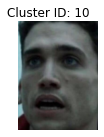

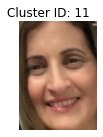

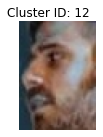

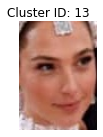

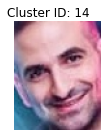

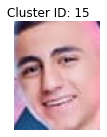

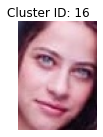

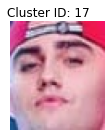

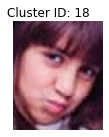

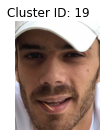

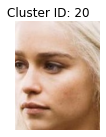

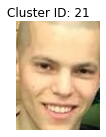

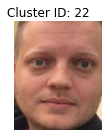

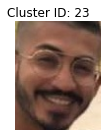

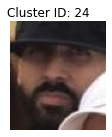

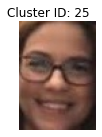

In [5]:
method = 'dbscan'

if method == 'kmeans':
    final_k = 20  # Adjust this k according to the elbow method
    clusters, _ = run_kmeans(embeddings, final_k)
elif method == 'dbscan':
    min_samples, eps= 21, 1 # Adjust this eps & min_samples according to the distance matrix
    clusters = run_dbscan(embeddings, eps=21, min_samples=1)
    

clusters_images = {str(cluster): {'images': [], 'indices': []} for cluster in np.unique(clusters)}

for image, cluster, index in zip(images, clusters, indices):
    clusters_images[str(cluster)]['images'].append(image)
    clusters_images[str(cluster)]['indices'].append(index)

for cluster_id, images_per_cluster in clusters_images.items():
    fig, axs = plt.subplots(1, len(images_per_cluster['images']), figsize=(10, 2))
    plt.suptitle(f'Cluster ID: {cluster_id}')
    
    if len(images_per_cluster['images']) == 1:
        axs = [axs] 

    for i, img in enumerate(images_per_cluster['images']):
        axs[i].imshow(img)
        axs[i].axis('off')  

    plt.show()

## Build an appearance graph
An edge is established between cluster A and cluster B if there exists at least one instance where both clusters contain faces that have appeared together in the same image.

In [6]:
idx_matrix = np.zeros((len(np.unique(clusters)), len(np.unique(indices))))

for cluster_id, cluster_value in clusters_images.items():
    idx_matrix[int(cluster_id)][cluster_value['indices']] = 1

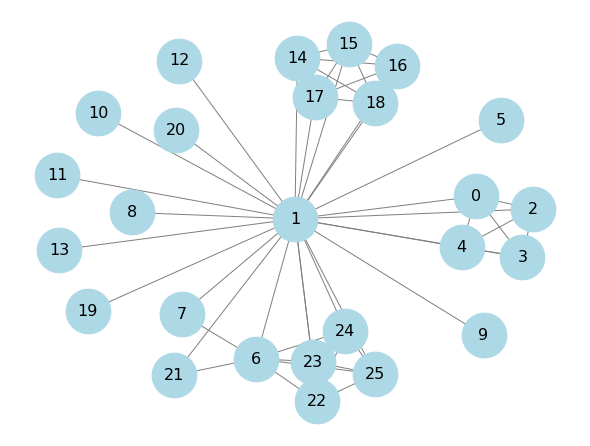

In [7]:
total_pairs = []

for index in range(idx_matrix.shape[1]):
    same_image = np.where(idx_matrix[:, index] == 1)[0]
    if len(same_image) > 1:
        pairs = list(itertools.combinations(same_image, 2))
        total_pairs += pairs

G = nx.Graph()
G.add_edges_from(total_pairs)

plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=2000, font_size=16)
plt.show()

At this point, we aim to identify the node whose removal results in the greatest increase in the number of connected components (The acount owner node).

In [8]:
def find_critical_node(graph):
    initial_components = nx.number_connected_components(graph)
    max_increase = 0
    critical_node = None
    
    for node in graph.nodes:
        G_copy = graph.copy()
        G_copy.remove_node(node)
        new_components = nx.number_connected_components(G_copy)
        increase = new_components - initial_components
        
        if increase > max_increase:
            max_increase = increase
            critical_node = node
            
    return critical_node, max_increase

critical_node, max_increase = find_critical_node(G)

print(f"The critical node is {critical_node} which increases the number of connected components by {max_increase} when removed.")

The critical node is 1 which increases the number of connected components by 11 when removed.


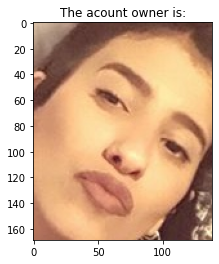

In [9]:
plt.title("The acount owner is:")
plt.imshow(clusters_images[str(critical_node)]['images'][0])
plt.show()

Remove the result folder

In [10]:
shutil.rmtree('result')